# Automatic Event Driven Trading
Here in this workbook we implement an event driven trading strategy using simple moving averages and tick data from yahoo finance with a tick period of one day.

First, we implement a financial data class to show how to load financial data from yahoo finance. Second, we create an order management class to process tick data, place buy and sell orders, the class also closes out our position at the end of the trading strategy period and measures the performance. Third, using the financial data and order mangement classes we create a trading strategy class where we implement a simple moving average crossover strategy. Using the tick data we can optionally choose to run the trading strategy with a stop-loss or not. 

We also provide methods to optimize the strategy for the best moving average parameters to maximize returns. Furthermore we provide methods to export the data to Excel and an analysis method to compute the equity curve performance metrics including sharpe ratio and drawdown information.

In [1]:
# Import Modules
import os
import pandas as pd
import yfinance as yf
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

# Magic function to enable matplotlib charting in jupyter notebooks
%matplotlib inline

# Allow Cell Multi Printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

# Reading Financial Data
This class will download financial data from yahoo finance and append daily return information. We also provide utility methods to display and plot the underlying data.

In [2]:
# This class will download data from yahoo finance
class FinancialData:
    
    # Class constructor to store parameters, download and format data
    def __init__(self, ticker, startDate, endDate):
        
        # Member Data
        self.ticker = ticker
        self.startDate = startDate
        self.endDate = endDate

        # Download and Format Data
        self.download_data()
        self.prepare_data()

    # Download data from yahoo finance
    def download_data(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        self.raw_data = yf.download(self.ticker, self.startDate, self.endDate)
        print(f"Download Complete")
        
    # Compute returns and drop NaN values
    def prepare_data(self):
        
        # Copy columns of interest
        # Note: when copying a DataFrame column we automatically keep the index column i.e. the date column
        copy_columns = ["Adj Close"]
        self.data = self.raw_data[copy_columns].copy()
        
        # Compute returns and drop NaN values
        # We use simple returns for consistency with the trading strategy class below
        
        # Log Returns
        #self.data["Returns"] = np.log(self.data["Adj Close"] / self.data["Adj Close"].shift(1))
        
        # Simple Returns
        self.data["Returns"] = (self.data["Adj Close"] / self.data["Adj Close"].shift(1)) - 1
        
        self.data.dropna(inplace=True)
    
    def plot_data(self, cols=None):
        if cols is None:
            cols = ["Adj Close"]
        self.data[cols].plot(title=self.ticker)
        
    # Show data head and tail
    def show_data(self, nRows=-1):
        
        if (nRows <= 0):
            nRows = 5
        
        print("\n*** HEAD ***")
        print(self.data.head(nRows))

        print("\n*** TAIL ***")
        print(self.data.tail(nRows))


# Example: Download Financial Data
Here we give an example of how to download daily data from yahoo finance. We also display and chart the data using the "show_data" method and "plot_data" methods.

[*********************100%***********************]  1 of 1 completed
Download Complete

*** HEAD ***
             Adj Close   Returns
Date                            
2021-09-27  216.294220 -0.019066
2021-09-28  206.697784 -0.044368
2021-09-29  204.880341 -0.008793
2021-09-30  206.867554  0.009699
2021-10-01  207.127167  0.001255

*** TAIL ***
             Adj Close   Returns
Date                            
2023-10-13  454.609985 -0.031612
2023-10-16  460.950012  0.013946
2023-10-17  439.380005 -0.046795
2023-10-18  421.959991 -0.039647
2023-10-19  421.010010 -0.002251


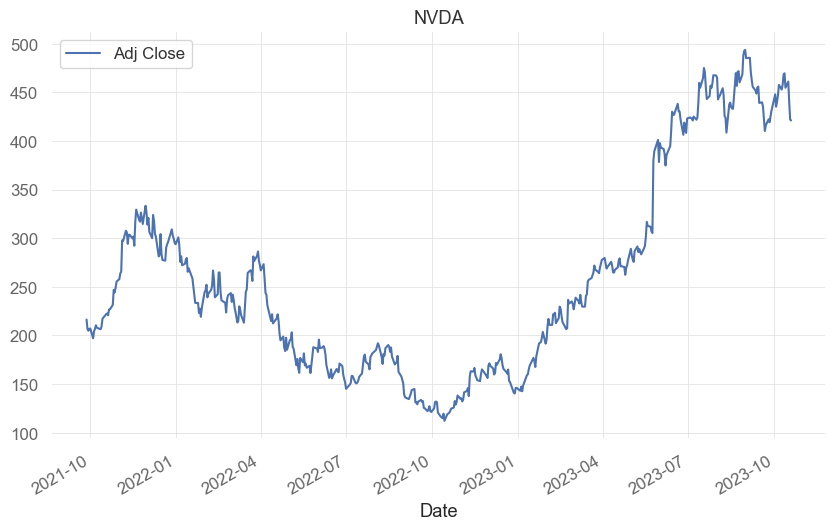

In [5]:
# 1. Define Ticker
ticker = "NVDA"

# 2. Define Data Period
nYears = 3

# Sytax for a specific end date
# endDate = dt.datetime(2021,6,30).date()

endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Load Data
fd = FinancialData(ticker, startDate, endDate)

# 4. Show Data (Optional)
fd.show_data()

# 5. Plot Data (Optional)
fd.plot_data()

# Order Management System
This is an order management back test class, where 'bar' represents a data tick. Bar is a number used to get the nth tick data item. The order management class takes care of portfolio cash balances, net wealth (P&L), placing a buy or sell order, closing out positions at the end of strategy and measuring performance.

In [104]:
# The order management class inherits the financial data class
class OrderManagement(FinancialData):
    
    # constructor
    def __init__(self, ticker, startDate, endDate, cash):
        
        # initialize the financial data parent class
        super().__init__(ticker, startDate, endDate)
        
        self.initial_balance = cash
        self.current_balance = cash
        self.qty = 0
        self.trades = 0
        self.total_return = 0

    # The 'bar' variable controls the tick data i.e. the get the nth tick data item
    def get_date_price(self, bar):
        
        # Throw an error if the nth data item does not exist i.e. is larger than our data set
        if bar > len(self.data):
            raise ValueError(f"Error: Tick data item {bar} is larger than the data set size {len(self.data)}")
        
        # Convert date index to a string then take the first 10 chars yyyy-mm-dd (i.e. 10 chars)
        date = str(self.data.index[bar])[:10]
        price = self.data["Adj Close"].iloc[bar]
        return date, price
    
    def print_initial_balance(self):
        print(f"initial balance = {self.initial_balance:.2f}")
        
    def print_balance(self):
        print(f"current balance = {self.current_balance:.2f}")
        
    def print_net_wealth(self):
        net_wealth = self.current_balance - self.initial_balance
        print(f"net wealth = {net_wealth:.2f}")
    
    # Place a buy order, we can specify buy qty or the cash amount
    def place_buy_order(self, bar=None, qty=None, amount=None):
        
        # Get transaction date and price for the nth tick data item
        date, price = self.get_date_price(bar)
        
        # Compute qty if specified as a cash amount
        if qty is None:
            qty = int(amount/price)
        
        # Update account balance and transaction history
        self.current_balance -= qty * price
        self.qty +=qty
        self.entry_price = price # last order price
        self.trades += 1
        
        # Print transaction details
        print(55 * "=")
        print(f"{date} | Bought {qty} units of {self.ticker} for {price:.2f} (total qty {self.qty})")
        self.print_balance()
        
    # Place a sell order, we can specify sell qty or the cash amount
    def place_sell_order(self, bar=None, qty=None, amount=None):
        
        # Get transaction date and price for the nth tick data item
        date, price = self.get_date_price(bar)
        
        # Compute qty if specified as a cash amount
        if qty is None:
            qty = int(amount/price)
        
        # Update account balance and transaction history
        self.current_balance += qty * price
        self.qty -=qty
        self.entry_price = price # last order price
        self.trades += 1
        
        # Print transaction details
        print(55 * "=")
        print(f"{date} | Sold {qty} units of {self.ticker} for {price:.2f} (total qty {self.qty})")
        self.print_balance()
    
    # Close all positions
    def close_out(self, bar):
        
        # Get transaction date and price for the nth tick data item
        date, price = self.get_date_price(bar)
        
        # Print transaction details
        print(55 * "=")
        print(f"*** CLOSING OUT POSITIONS & PERFORMANCE SUMMARY***")
        
        if (self.qty == 0):
            print("No Positions to Close")
        else:
            print(f"{date} | Closing out {self.qty} of {self.ticker} for {price:.2f}")
        
        # Update account balance and transaction history
        self.current_balance += self.qty * price
        self.qty = 0
        
        # Print Performance Summary
        self.print_initial_balance()
        self.print_balance()
        self.print_net_wealth()
        self.total_return = ((self.current_balance / self.initial_balance) -1) * 100
        print(f"total return[%] = {self.total_return:.3f}%")
        print(f"trades = {self.trades}")
        

# Example: Trading Strategy & Order Management System
Here we import a large sample of equity data for a single stock. We then initialize a trading portfolio and place some trades at different time intervals, specified using the 'bar' parameter. Here in this case we are downloading data from yahoo finance where the tick interval is in days. In this example, we execute several transactions and then close out our position before measuring the performance of our trading portfolio.

In [105]:
# 1. Define Ticker
ticker = "NVDA"

# 2. Define Data Period
nYears = 3
endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Specify Initial Cash
initialCash = 1000000

# 3. Initialize portfolio and Order Management System class
tradingStrategy = OrderManagement(ticker, startDate, endDate, initialCash)

# 4. Display Price Data
tradingStrategy.data.head()

# 5. Execute Some Transactions
tradingStrategy.place_buy_order(bar=100, qty=1000)
tradingStrategy.place_buy_order(bar=200, qty=1000)
tradingStrategy.place_buy_order(bar=300, qty=1000)
tradingStrategy.place_buy_order(bar=400, qty=1000)
tradingStrategy.place_buy_order(bar=500, qty=1000)

# 6. Close Out Any Open Positions and Generate Performance Summary 
tradingStrategy.close_out(100)


[*********************100%***********************]  1 of 1 completed
Download Complete


,Adj Close,Returns
Date,,
2021-09-27,216.294220,-0.019066
2021-09-28,206.697800,-0.044367
2021-09-29,204.880341,-0.008793
2021-09-30,206.867538,0.009699
2021-10-01,207.127136,0.001255


2022-02-17 | Bought 1000 units of NVDA for 244.75 (total qty 1000)
current balance = 755246.05
2022-07-14 | Bought 1000 units of NVDA for 153.58 (total qty 2000)
current balance = 601665.65
2022-12-05 | Bought 1000 units of NVDA for 166.04 (total qty 3000)
current balance = 435624.69
2023-05-01 | Bought 1000 units of NVDA for 289.05 (total qty 4000)
current balance = 146578.40
2023-09-22 | Bought 1000 units of NVDA for 416.10 (total qty 5000)
current balance = -269521.61
*** CLOSING OUT POSITIONS & PERFORMANCE SUMMARY***
2022-02-17 | Closing out 5000 of NVDA for 244.75
initial balance = 1000000.00
current balance = 954248.15
net wealth = -45751.85
total return[%] = -4.575%
trades = 5


# Trading Strategy Example - Simple Moving Average (SMA) Crossover
Next we inherit the Order Management class implemented above and use it to back test a simple moving average crossover trading strategy. The order management base class provides the following functionality:-

- `__init__` (The order management portfolio constructor)
- retrieve_data
- prepare_data
- plot_data
- get_date_price (i.e. get tick data)
- print_balance
- print_net_wealth
- place_buy_order
- place_sell_order
- close_out (to close out strategy positions and generate performance statistics)

Using these base class methods we implement a tick-data event based trading strategy back testing class. The strategy is relatively straightforward, given a short and long moving average indicator, whenever there is a up crossover we go long and exit any short position. Similarly, whenever there is a down crossover we go short and exit any long positions.


In [114]:
class SMATradingStrategy(OrderManagement):
    
    # Internal method to generate the short and long simple moving average data, here labelled SMA1 and SMA2
    def generate_moving_averages(self):
        self.data["SMA1"] = self.data["Adj Close"].rolling(self.SMA1).mean()
        self.data["SMA2"] = self.data["Adj Close"].rolling(self.SMA2).mean()

    # The trading strategy constructor
    # ================================
    # SMA1 (short) and SMA2 (long) are the simple moving average days e.g. 10 and 20 days respectively
    # stoploss = stop loss in percent
    # timeout = if a stop loss is triggered then a timeout default of 5 bars or tick periods is observed (here in days)
    def backtest_strategy(self, SMA1, SMA2, qty, stoploss=None, timeout=5):
        
        if (SMA2 <= SMA1):
            raise ValueError(f"Error: Simple Moving Average - Short average days {SMA1} must be less than the long average days {SMA2}")
            
        # Store the Simple Moving Average days and generate the moving averages
        self.SMA1, self.SMA2 = SMA1, SMA2
        self.generate_moving_averages()
        
        # Reset Strategy Parameters
        self.timeout = 0 
        self.qty = 0
        self.trades = 0
        self.position = 0
        self.total_return = 0
        self.current_balance = self.initial_balance
        
        print(55 * "=")
        print(f"*** START BACKTEST ***")
        print(f"Ticker={self.ticker} | SMA1={self.SMA1} | SMA2={self.SMA2} | Qty={qty}")
        
        # Track Passive Returns (i.e. buy and hold), Strategy Returns and Position
        self.data["strategy_position"] = 0
        self.data["passive_returns"] = self.data["Returns"]
        self.data["strategy_returns"] = 0
                
        # Process each tick period (here measured in days)
        # The first SMA2 long moving average tick periods will be N/A so ignore these periods
        for bar in range(SMA2 - 1, len(self.data)):
        
            # Track Strategy performance from previous tick data bar
            # We simply scale the passive returns for each bar by our position, where 1=long, -1=short or 0=no position
            self.data["strategy_returns"].iloc[bar] = self.data["passive_returns"].iloc[bar] * self.position
            self.data["strategy_position"].iloc[bar] = self.position
        
            # If stop loss is hit, we must wait before the next trade (time-out)
            # The time-out will count down to zero
            if self.timeout > 0:
                self.timeout -= 1
            else:
                self.timeout = 0
    
            # Get the tick date and price using the bar index
            date, price = self.get_date_price(bar)
        
            # Stop Loss Code (stoploss = stop loss in percent, ret = current return)
            # =====================================================
            
            # Stop loss trades are only executued if a stop loss level is provided
            # We are only allowed if trade if the timeout is zero
            if stoploss is not None and stoploss > 0 and self.position != 0 and self.timeout == 0:
                
                # Current Return
                ret = (price / self.entry_price) - 1
                
                # Check for Long Position and Stop Loss Trigger
                if self.position == 1 and ret < -stoploss:
                
                    print(55 * "=")
                    print(f"{date} | STOP LOSS HIT | Closing LONG Position | Loss of {ret * 100:.2f}%")
                    
                    # Close Long Position and Trigger Timeout
                    self.place_sell_order(bar, qty=self.qty)
                    self.position = 0
                    self.timeout = timeout
            
                # Check for Short Position and Stop Loss Trigger
                elif self.position == -1 and ret > stoploss:
                    
                    print(55 * "=")
                    print(f"{date} | STOP LOSS HIT | Closing SHORT Position | Loss of {ret * 100:.2f}%")
                    
                    # Close Short Position and Trigger Timeout
                    self.place_buy_order(bar, qty=self.qty)
                    self.position = 0
                    self.timeout = timeout

            # Trade the Signal
            # ================
            
            # Generate a long signal (signal = 1) if SMA1 the short moving average crosses over SMA2 the long moving average
            # Otherwise generate a short signal (signal = -1)
            signal = 1 if self.data["SMA1"].iloc[bar] >= self.data["SMA2"].iloc[bar] else -1
            
            # LONG SIGNAL
            # ===========
            
            # We are only allowed if trade if the timeout is zero
            if self.position in [0, -1] and signal == 1 and self.timeout == 0:
            
                # If our position is neutral or short then place a buy order to go long
                # For short positions buy x2 qty i.e. to close the short and go long
                self.place_buy_order(bar, qty=(1-self.position)*qty)
                self.position = 1
            
            # SHORT SIGNAL
            # ============
            
            # We are only allowed if trade if the timeout is zero
            elif self.position in [0, 1] and signal == -1 and self.timeout == 0:
                
                # If our position is neutral or long then place a sell order to go short
                # For long positions sell x2 qty i.e. to close the long and go short
                self.place_sell_order(bar, qty=(1+self.position)*qty)
                self.position = -1
        
        # Close-Out Positions and Measure Performance
        # ===========================================
        final_position = self.position
        
        self.close_out(bar)
    
        # Track Strategy performance for closeout
        self.data["strategy_returns"].iloc[bar] = self.data["passive_returns"].iloc[bar]
        self.data["strategy_position"].iloc[bar] = final_position
    
    # This method searches for the most optimal SMA1 and SMA2 parameters that control the short and long term moving average parameters
    # Here optimal means the find the combination of parameters that give the highest total return
    def optimize(self, qty, shortDayList=[2,3,4,5,6,7,8,9,10], longDayList=[10,11,12,13,14,15,16,17,18,20,25,30,35,40,45,50], useOptimalParams=True):
        
        print(f"*** Searching for Optimal Results ***")
        
        bestReturn = -999
        bestShortDays = 0
        bestLongDays = 0
        
        # Track Original Moving Average Parameters
        self.originalShortDays = self.SMA1
        self.originalLongDays = self.SMA2
        
        # Iterate over shortDay- and longDayLists to final optimal parameters
        for shortDays in shortDayList:
            for longDays in longDayList:
                
                # Update Moving Average Parameters
                self.SMA1 = shortDays
                self.SMA2 = longDays
                
                # Run the Strategy with the New Parameters
                self.backtest_strategy(self.SMA1, self.SMA2, qty)
                thisReturn = self.total_return 
                
                # Print Iteration Results
                print(f"ShortDays: {shortDays}, LongDays: {longDays}, Total Return: {thisReturn}")
                
                # Track Best Parameters
                if  thisReturn > bestReturn:
                    bestReturn = thisReturn
                    bestShortDays = self.SMA1
                    bestLongDays = self.SMA2
        
        # Set Best Moving Average Parameters
        self.SMA1 = bestShortDays
        self.SMA2 = bestLongDays

        # Use Optimal Parameters if requested 
        if (useOptimalParams == False):
            
            # If requested, restore Original Moving Average Parameters
            self.SMA1 = self.originalShortDays
            self.SMA2 = self.originalLongDays
        
        # Restore Underlying Strategy Data, o.w. data from last iteration will persist
        self.backtest_strategy(self.SMA1, self.SMA2, qty)
        
        print()
        print(f"*** Strategy Optimization Results ***")
        print(f"Best Short Days: {bestShortDays}")
        print(f"Best Long Days: {bestLongDays}")
        print(f"UseOptimalParameters: {useOptimalParams}")
        print(f"Strategy Settings - Moving Average Short Days: {self.SMA1}")
        print(f"Strategy Settings - Moving Average Long Days: {self.SMA2}")
        print(f"Total Return: {self.total_return}")


    # Method to export the DataFrame results
    def export(self, filename=None):
        if filename is None:
            filename = "StrategyData.xlsx"
        self.data.to_excel(filename, sheet_name="StrategyData", index=True)
        print(f"Exported Strategy Data to Excel: {filename}")
        
    # Method to generate Equity Curve performance metrics for our trading strategy using the QuantStats library
    # Results here are for an equity curve and will not match the back_test returns where we invest in a fixed qty
    # of the underlying asset and not our entire capital.
    def analysis(self):
        qs.reports.basic(self.data["strategy_returns"])
        
        

# Running the Trading Strategy
Here we run the simple moving average crossover strategy. We can run the strategy with a stop loss or without. We can also optimize for the best moving average parameters SMA1 and SMA2 to use, these represent the short-term and long-term moving average parameters respectively.

The backtest_strategy method will display all transactions entered and report the total return and profit/loss. The optimize method will select the best short-term (SM1) and long-term (SMA2) parameters for the trading strategy. The analysis method will compute an equity curve and corresponding strategy performance metrics, these results will be different from the backtest results where we invest in a fixed quantity of the underlying asset without investing our entire capital. Finally, we can export the strategy data to Excel for debugging and to inspect the data and calculations using the export method.

[*********************100%***********************]  1 of 1 completed
Download Complete
*** START BACKTEST ***
Ticker=NVDA | SMA1=7 | SMA2=14 | Qty=1000
2021-10-14 | Bought 1000 units of NVDA for 217.15 (total qty 1000)
current balance = 782847.02
2021-12-08 | Sold 2000 units of NVDA for 317.85 (total qty -1000)
current balance = 1418546.23
2021-12-29 | Bought 2000 units of NVDA for 299.62 (total qty 1000)
current balance = 819299.96
2022-01-05 | STOP LOSS HIT | Closing LONG Position | Loss of -7.99%
2022-01-05 | Sold 1000 units of NVDA for 275.68 (total qty 0)
current balance = 1094984.01
2022-01-12 | Sold 1000 units of NVDA for 279.63 (total qty -1000)
current balance = 1374612.92
2022-02-04 | Bought 2000 units of NVDA for 242.88 (total qty 1000)
current balance = 888860.14
2022-02-22 | Sold 2000 units of NVDA for 233.60 (total qty -1000)
current balance = 1356056.88
2022-03-17 | STOP LOSS HIT | Closing SHORT Position | Loss of 5.90%
2022-03-17 | Bought -1000 units of NVDA for 247.38 

                    Strategy
------------------  ----------
Start Period        2021-09-27
End Period          2023-10-19
Risk-Free Rate      0.0%
Time in Market      88.0%

Cumulative Return   276.68%
CAGR﹪              55.96%

Sharpe              1.44
Prob. Sharpe Ratio  98.44%
Sortino             2.42
Sortino/√2          1.71
Omega               1.3

Max Drawdown        -38.08%
Longest DD Days     181

Gain/Pain Ratio     0.3
Gain/Pain (1M)      2.88

Payoff Ratio        1.2
Profit Factor       1.3
Common Sense Ratio  1.57
CPC Index           0.81
Tail Ratio          1.21
Outlier Win Ratio   3.89
Outlier Loss Ratio  2.94

MTD                 -5.75%
3M                  -11.58%
6M                  41.21%
YTD                 107.39%
1Y                  147.02%
3Y (ann.)           55.96%
5Y (ann.)           55.96%
10Y (ann.)          55.96%
All-time (ann.)     55.96%

Avg. Drawdown       -7.43%
Avg. Drawdown Days  19
Recovery Factor     4.29
Ulcer Index         0.14
Serenity Index      

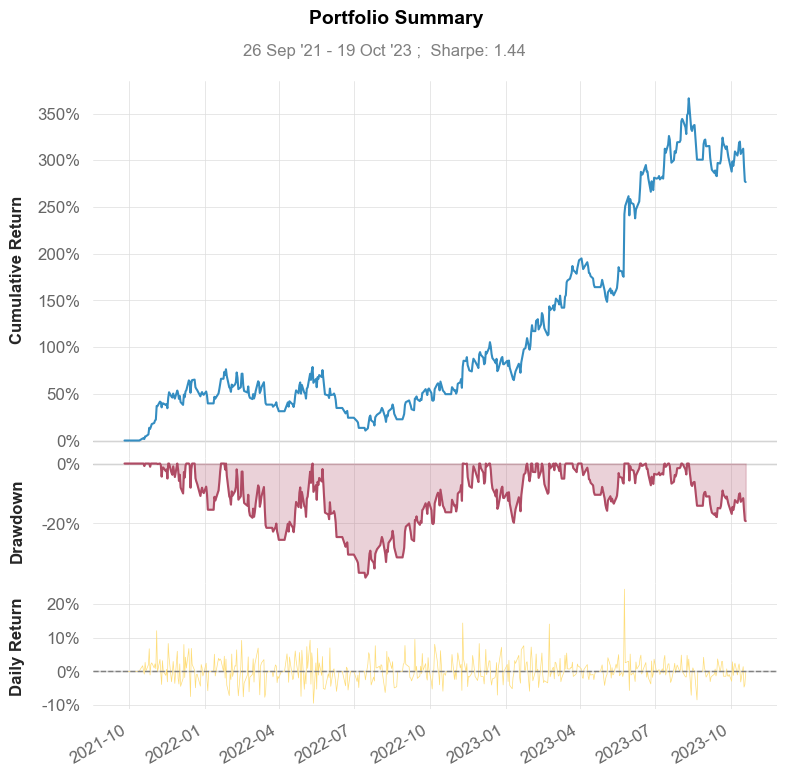

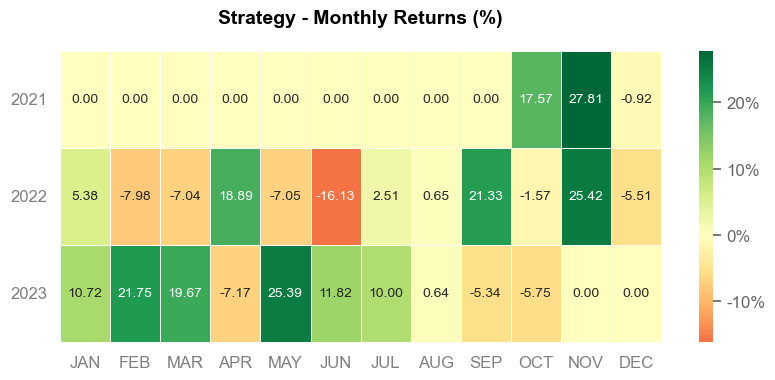

Exported Strategy Data to Excel: StrategyData.xlsx


In [118]:
# 1. Define Ticker
ticker = "NVDA"

# 2. Define Data Period
nYears = 3
endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Specify Initial Cash
initialCash = 1000000

# 3. Initialize the Simple Moving Average (SMA) Trading Strategy
sma = SMATradingStrategy(ticker, startDate, endDate, initialCash)

# View Underlying Strategy Data (Uncomment to Activate)
#sma.show_data()
#sma.plot_data()

# 4. Run the Back Test - Specify the stop loss in percent or set it to zero to disable
sma.backtest_strategy(SMA1=7, SMA2=14, qty=1000, stoploss=0.05)

# 5. Optimize the Trading Strategy Moving Average Parameters
#sma.optimize(qty=10000, shortDayList=[2,3,4,5,6,7,8,9,10], longDayList=[11,12,13,14,15,16,17,18,20,25,30,35,40,45,50])

# 6. Analyze Strategy Performance
# QuantStats analysis uses the unit daily returns and computes the equity curve return profile
# This will be different from the backtest results where we invest in a fixed qty the underlying asset
sma.analysis()

# 7. Export Strategy Results to Excel, default filename="StrategyData.xlsx"
# This is useful for debugging and to verify results
#sma.export()